# Import Libraries

In [50]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [2]:
pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.2 MB/s eta 0:00:00


In [54]:

from faker import Faker
fake = Faker()
# Set random seed for reproducibility
np.random.seed(42)
# Number of users and posts
n_users = 500
n_posts_per_user = 2000
n_records = n_users * n_posts_per_user
# Generate user IDs
user_ids = [fake.uuid4() for _ in range(n_users)]
# Generate post IDs
post_ids = [fake.uuid4() for _ in range(n_posts_per_user)]
# Generate data
data = {
    'User_ID': [random.choice(user_ids) for _ in range(n_records)],
    'Post_ID': post_ids * n_users,
    'Interaction_Type': np.random.choice(['like', 'comment', 'share', 'seen'], n_records),
    'Interaction_Timestamp': [fake.date_time_between(start_date='-30d', end_date='now') for _ in range(n_records)],
    'Post_Content': [fake.text(max_nb_chars=200) for _ in range(n_posts_per_user)] * n_users,
    'Post_Timestamp': [fake.date_time_between(start_date='-60d', end_date='-30d') for _ in range(n_posts_per_user)] * n_users
}
# Create DataFrame
df = pd.DataFrame(data)
# Sort by Interaction_Timestamp
df = df.sort_values('Interaction_Timestamp')
# Save to CSV
df.to_csv('synthetic_user_interaction_data.csv', index=False)


In [55]:
df = pd.read_csv('/content/synthetic_user_interaction_data.csv')

# Convert timestamp strings to datetime objects
df['Interaction_Timestamp'] = pd.to_datetime(df['Interaction_Timestamp'])
df['Post_Timestamp'] = pd.to_datetime(df['Post_Timestamp'])

In [56]:
df.head()

,User_ID,Post_ID,Interaction_Type,Interaction_Timestamp,Post_Content,Post_Timestamp
0,5e46dc4b-1741-4f2b-aa98-d1e05146aba6,e1d1224d-983d-40c5-90fe-f282083e485f,like,2024-05-23 06:25:49.357111,Teach money trip including him team bill. Yes ...,2024-05-07 22:35:51.106624
1,ff04813c-af70-4197-ac7f-047ca3388285,a0b2a38f-8b47-47ef-9297-48abcb636fc9,comment,2024-05-23 06:25:51.428871,Art movie success sing politics full.\nHowever...,2024-05-17 16:24:53.842373
2,0dba18d0-721a-4ebd-afe7-e0e10968c04d,ab174921-acbe-4983-801f-8c124df21455,comment,2024-05-23 06:25:58.137119,Magazine grow behind yet language stock thus. ...,2024-04-30 17:18:19.065501
3,07d2b29b-3c9c-4541-a139-17b0c6d3d310,c83620f6-246a-4d9b-9267-2c055ab30fd8,share,2024-05-23 06:26:02.631612,Board without near prove. Position year though...,2024-05-10 13:26:46.653625
4,d595cdad-53d6-4e7b-8a4a-03f82fbc394b,4c5463f3-bb83-46e1-84d4-1b90be1b9e9e,share,2024-05-23 06:26:05.207206,Whom probably kind wonder. Not poor name visit...,2024-04-27 11:17:59.243271


In [57]:
df['User_ID'].nunique()

500

# Feature Engineering


In [58]:
#Interaction Features
interaction_counts = df.groupby(['User_ID', 'Post_ID', 'Interaction_Type']).size().unstack(fill_value=0)
interaction_counts.columns = [f'{col}_count' for col in interaction_counts.columns]
df = df.merge(interaction_counts, on=['User_ID', 'Post_ID'], how='left')


In [59]:
interaction_counts.head()

comment_count  \
User_ID                              Post_ID                                               
017c0f1e-810c-4130-9cd6-06f201b1453c 00305f06-07f1-4805-89dd-2f52eb857d70              0   
                                     007bbdec-d5ed-47a1-8593-b031d6d6c923              0   
                                     00988eee-4347-4c73-9b43-a1e196f2d6e8              1   
                                     00bebcce-e56d-4a04-8a78-e068968310fe              0   
                                     00bfbca6-5e4f-467c-accf-261dc61d2f6b              0   

                                                                           like_count  \
User_ID                              Post_ID                                            
017c0f1e-810c-4130-9cd6-06f201b1453c 00305f06-07f1-4805-89dd-2f52eb857d70           0   
                                     007bbdec-d5ed-47a1-8593-b031d6d6c923           1   
                                     00988eee-4347-4c73-9b43-a1e196f2d6e8           0   
                                     00bebcce-e56d-4a04-8a78-e068968310fe           0   
                                     00bfbca6-5e4f-467c-accf-261dc61d2f6b           0   

                                                                           seen_count  \
User_ID                              Post_ID                                            
017c0f1e-810c-4130-9cd6-06f201b1453c 00305f06-07f1-4805-89dd-2f52eb857d70           1   
                                     007bbdec-d5ed-47a1-8593-b031d6d6c923           0   
                                     00988eee-4347-4c73-9b43-a1e196f2d6e8           0   
                                     00bebcce-e56d-4a04-8a78-e068968310fe           1   
                                     00bfbca6-5e4f-467c-accf-261dc61d2f6b           1   

                                                                           share_count  
User_ID                              Post_ID                                            
017c0f1e-810c-4130-9cd6-06f201b1453c 00305f06-07f1-4805-89dd-2f52eb857d70            0  
                                     007bbdec-d5ed-47a1-8593-b031d6d6c923            0  
                                     00988eee-4347-4c73-9b43-a1e196f2d6e8            0  
                                     00bebcce-e56d-4a04-8a78-e068968310fe            0  
                                     00bfbca6-5e4f-467c-accf-261dc61d2f6b            1

In [60]:
#Content Features
tfidf = TfidfVectorizer(max_features=100)
tfidf_matrix = tfidf.fit_transform(df['Post_Content'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{i}' for i in range(100)])
df = pd.concat([df, tfidf_df], axis=1)


In [61]:
df.head()

,User_ID,Post_ID,Interaction_Type,Interaction_Timestamp,Post_Content,Post_Timestamp,comment_count,like_count,seen_count,share_count,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
0,5e46dc4b-1741-4f2b-aa98-d1e05146aba6,e1d1224d-983d-40c5-90fe-f282083e485f,like,2024-05-23 06:25:49.357111,Teach money trip including him team bill. Yes ...,2024-05-07 22:35:51.106624,0,1,0,0,...,0.0,0.711384,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
1,ff04813c-af70-4197-ac7f-047ca3388285,a0b2a38f-8b47-47ef-9297-48abcb636fc9,comment,2024-05-23 06:25:51.428871,Art movie success sing politics full.\nHowever...,2024-05-17 16:24:53.842373,3,1,0,0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
2,0dba18d0-721a-4ebd-afe7-e0e10968c04d,ab174921-acbe-4983-801f-8c124df21455,comment,2024-05-23 06:25:58.137119,Magazine grow behind yet language stock thus. ...,2024-04-30 17:18:19.065501,2,0,0,1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.708515
3,07d2b29b-3c9c-4541-a139-17b0c6d3d310,c83620f6-246a-4d9b-9267-2c055ab30fd8,share,2024-05-23 06:26:02.631612,Board without near prove. Position year though...,2024-05-10 13:26:46.653625,0,0,0,1,...,0.0,0.000000,0.0,0.0,0.451633,0.0,0.0,0.0,0.0,0.000000
4,d595cdad-53d6-4e7b-8a4a-03f82fbc394b,4c5463f3-bb83-46e1-84d4-1b90be1b9e9e,share,2024-05-23 06:26:05.207206,Whom probably kind wonder. Not poor name visit...,2024-04-27 11:17:59.243271,0,0,2,1,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


In [62]:
#Temporal Features
df['Post_Age'] = (df['Interaction_Timestamp'] - df['Post_Timestamp']).dt.total_seconds() / 3600  # in hours

# Create target variable (1 if user interacted, 0 if just seen)
df['Interacted'] = (df['Interaction_Type'] != 'seen').astype(int)

# Model Development


In [63]:
# Prepare features for the model
feature_columns = ['like_count', 'comment_count', 'share_count', 'seen_count', 'Post_Age'] + [f'tfidf_{i}' for i in range(100)]
X = df[feature_columns]
y = df['Interacted']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [64]:
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)


LogisticRegression(random_state=42)

In [65]:

# Evaluate the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")



Accuracy: 0.8782
Precision: 0.9512
Recall: 0.8830
Cross-validation scores: [0.87878125 0.87765    0.87829375 0.87786875 0.87679375]
Mean CV score: 0.8779


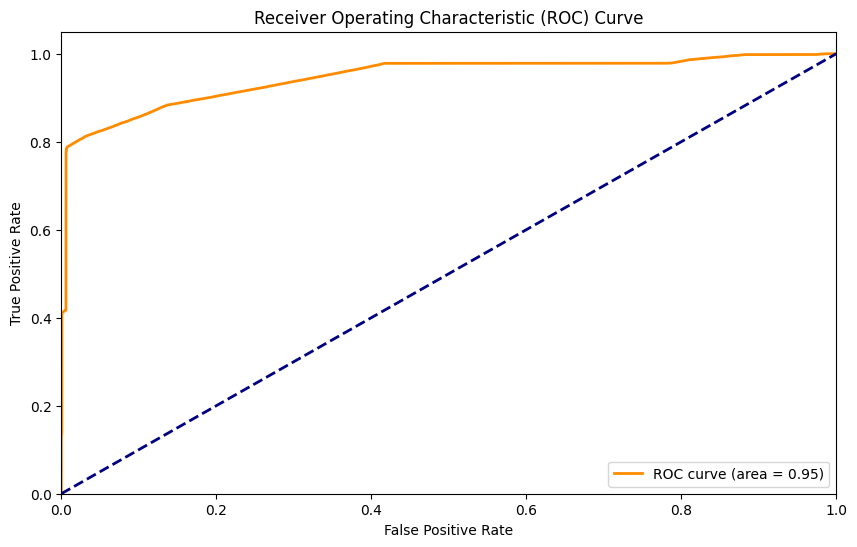

In [69]:
# ROC Curve
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc

# Feed Generation

In [67]:
def generate_personalized_feed(user_id, n_posts=10):
    user_posts = df[df['User_ID'] == user_id].drop_duplicates(subset=['Post_ID']).copy()

    if user_posts.empty:
        return "No posts found for this user."

    # Prepare features for prediction
    X_user = user_posts[feature_columns]
    X_user_scaled = scaler.transform(X_user)
    # Predict relevance scores
    relevance_scores = model.predict_proba(X_user_scaled)[:, 1]
    # Add relevance scores to the dataframe
    user_posts.loc[:, 'Relevance_Score'] = relevance_scores
    # Calculate recency (in hours, max 30 days)
    max_age = 30 * 24  # 30 days in hours
    user_posts.loc[:, 'Recency_Score'] = np.minimum((datetime.now() - user_posts['Post_Timestamp']).dt.total_seconds() / 3600, max_age)
    # Normalize Recency_Score to be between 0 and 1
    user_posts.loc[:, 'Recency_Score'] = 1 - (user_posts['Recency_Score'] / max_age)
    # Calculate Final_Score as a weighted sum of Relevance and Recency
    relevance_weight = 0.7
    recency_weight = 0.3
    user_posts.loc[:, 'Final_Score'] = (
        relevance_weight * user_posts['Relevance_Score'] +
        recency_weight * user_posts['Recency_Score']
    )
    # Add a small random factor to break ties
    user_posts.loc[:, 'Final_Score'] += np.random.uniform(0, 0.001, size=len(user_posts))
    # Get top N posts
    top_posts = user_posts.sort_values('Final_Score', ascending=False).head(n_posts)
    return top_posts[['Post_ID', 'Post_Content', 'Final_Score', 'Relevance_Score', 'Recency_Score']]

In [68]:
sample_user_id = df['User_ID'].iloc[0]
personalized_feed = generate_personalized_feed(sample_user_id)
print("\nSample Personalized Feed:")
for i, (_, row) in enumerate(personalized_feed.iterrows(), 1):
    print(f"\n{i}. Post ID: {row['Post_ID']}")
    print(f"   Content: {row['Post_Content'][:100]}...")  # Show first 100 characters
    print(f"   Score: {row['Final_Score']:.4f}")


Sample Personalized Feed:

1. Post ID: 6b5d5bd8-d3a3-4a7d-9cc7-a85981404001
   Content: These describe admit economic enter agency. Measure worker senior woman mouth ago page.
Tough Americ...
   Score: 0.7006

2. Post ID: a0dbdf9d-8b80-4f46-ad54-ef74c89c1f0e
   Content: Official provide action generation five. News challenge draw evening. Rest into old international th...
   Score: 0.7005

3. Post ID: d9b2bfe4-3ac9-429f-823e-f7b701b304ff
   Content: This research between adult billion system moment. Ground total physical all statement trip.
Develop...
   Score: 0.7003

4. Post ID: a0f7c418-fd92-4ffd-9a21-55a46ba102a8
   Content: Democratic rate agent term west hold. Create organization name include course machine most....
   Score: 0.7003

5. Post ID: d13f7a98-2b82-4201-a0ef-537ada3bf1fe
   Content: Strong week method leave reflect year. Home civil term go opportunity field. Drop stop set go.
Than ...
   Score: 0.7002

6. Post ID: 86c13fbc-5a98-41f1-91c7-1fc30e3732b6
   Content: Presi